In [114]:
import requests
import pandas as pd
import os
import numpy as np

import seaborn as sns

from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

## Downloading data from server

In [7]:
def downloag_data(output_folder, stations_file, years_list):
    stations_df=pd.read_csv(stations_file, sep='\t', header = None)
    for year in years_list:        
        sub_output_folder=os.path.join(output_folder, year)
        os.mkdir(sub_output_folder)
        for index, row in stations_df.iterrows():
            prefix='CRND0103-%s-' % year
            file_name=(prefix+row[2]+'_'+row[3]+'_'+row[4]+'.txt').replace(' ', '_')

            #print('Collecting data:')
            #print(file_name)

            url = 'https://www1.ncdc.noaa.gov/pub/data/uscrn/products/daily01/%s/' % year

            try:
                r = requests.get(url+file_name, allow_redirects=True)
                if r.status_code==404:
                    #print ('This station is not in  dataset')
                    pass
                else:
                    #print ('Downloading...')
                    with open (os.path.join(sub_output_folder, file_name), 'wb') as file:
                        file.write(r.content)

            except Exception as e:
                print ('Server error:')
                print(e)

In [44]:
output_folder='C:/Users/Julia/Documents/ITMO/Statistical_data_analysis/Full_project/raw_data/'
stations_file='C:/Users/Julia/Documents/ITMO/Statistical_data_analysis/Full_project/stations.tsv'
years_list=['2016', '2017', '2018', '2019', '2020']
downloag_data(output_folder, stations_file, years_list)

## Removing splits in downloaded files

In [47]:
def separator_rewriting(input_data, output_folder):
    for data_folder in os.listdir(input_data):
        for file in os.listdir(os.path.join(input_data,data_folder)):
            with open (os.path.join(input_data, data_folder, file)) as old_file:
                l_list=old_file.readlines()
                for line in l_list:
                    while '  ' in line:
                        line=line.replace('  ', ' ')
                    with open (os.path.join(output_folder, file.split('-')[-1]), 'a') as new_file:
                        new_file.write(line)

In [46]:
parsed_data_folder='C:/Users/Julia/Documents/ITMO/Statistical_data_analysis/Full_project/parsed_by_station_data'
separator_rewriting(output_folder, parsed_data_folder)

## Removing stations with more than n gaps

In [48]:
def rewrite_full_dataset(input_folder, parameters_dict, gaps_number):
    for file in os.listdir(input_folder):
        df=pd.read_csv(os.path.join(input_folder, file), sep=' ', header=None)
        for item in parameters_dict:
            dataset=df[item['id']]
            (unique, counts) = np.unique(dataset, return_counts=True)
            unique_values=dict(zip(unique, counts))    
            if item['nodata'] in unique_values.keys() and unique_values[item['nodata']]>gaps_number:
                os.remove(os.path.join(input_folder, file))
                break                

In [49]:
parameters_dict=[{'id':1, 'name':'LST_DATE', 'nodata':-9999},
                 {'id':11, 'name':'SUR_TEMP_DAILY_TYPE', 'nodata':'R'},
                 {'id':14, 'name':'SUR_TEMP_DAILY_AVG', 'nodata':-9999}, 
                 {'id':23, 'name':'SOIL_TEMP_5_DAILY', 'nodata':-9999}, 
                 {'id':24, 'name':'SOIL_TEMP_10_DAILY', 'nodata':-9999}, 
                 {'id':25, 'name':'SOIL_TEMP_20_DAILY', 'nodata':-9999}, 
                 {'id':26, 'name':'SOIL_TEMP_50_DAILY', 'nodata':-9999}, 
                 {'id':27, 'name':'SOIL_TEMP_100_DAILY', 'nodata':-9999}]
gaps_number=(4*365+200)*0.1
rewrite_full_dataset(parsed_data_folder, parameters_dict, gaps_number)

## Finding dependencies in dataset variables

In [142]:
test_file='C:/Users/Julia/Documents/ITMO/Statistical_data_analysis/Full_project/parsed_by_station_data/WI_Necedah_5_WNW.txt'
df=pd.read_csv(test_file, sep=' ', header=None)
df[1] = pd.to_datetime(df[1], format='%Y%m%d')
df
filtered_df={'LST_DATE':df[1][550:],
            'SUR_TEMP_DAILY_AVG':df[14][550:],
            'SOIL_TEMP_5_DAILY':df[23][550:],
            'SOIL_TEMP_10_DAILY':df[24][550:],
            'SOIL_TEMP_20_DAILY':df[25][550:],
            'SOIL_TEMP_50_DAILY':df[26][550:],
            'SOIL_TEMP_100_DAILY':df[27][550:]}
filtered_df = pd.DataFrame(filtered_df, columns = ['LST_DATE', 'SUR_TEMP_DAILY_AVG', 'SOIL_TEMP_5_DAILY', 
                                                     'SOIL_TEMP_10_DAILY', 'SOIL_TEMP_20_DAILY', 
                                                     'SOIL_TEMP_50_DAILY', 'SOIL_TEMP_100_DAILY'])
filtered_df

,LST_DATE,SUR_TEMP_DAILY_AVG,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
550,2017-07-04,24.0,22.6,22.0,21.3,19.8,18.0
551,2017-07-05,24.1,23.1,22.4,21.8,20.2,18.3
552,2017-07-06,26.5,23.9,23.0,22.2,20.5,18.5
553,2017-07-07,24.1,23.7,23.3,22.6,20.8,18.7
554,2017-07-08,22.6,22.7,22.3,22.0,20.8,18.9
...,...,...,...,...,...,...,...
1766,2020-11-01,0.7,4.7,5.2,5.9,6.9,8.2
1767,2020-11-02,2.2,4.0,4.3,5.1,6.5,8.1
1768,2020-11-03,9.2,5.4,5.4,5.7,6.4,7.9
1769,2020-11-04,10.5,6.9,6.8,6.9,7.0,7.9


### Correlations matrix

In [143]:
filtered_df.corr()

,SUR_TEMP_DAILY_AVG,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
SUR_TEMP_DAILY_AVG,1.000000,0.952509,0.946310,0.936936,0.912370,0.877682
SOIL_TEMP_5_DAILY,0.952509,1.000000,0.999326,0.996837,0.985225,0.960843
SOIL_TEMP_10_DAILY,0.946310,0.999326,1.000000,0.998829,0.989802,0.967842
SOIL_TEMP_20_DAILY,0.936936,0.996837,0.998829,1.000000,0.995260,0.977667
SOIL_TEMP_50_DAILY,0.912370,0.985225,0.989802,0.995260,1.000000,0.992905
SOIL_TEMP_100_DAILY,0.877682,0.960843,0.967842,0.977667,0.992905,1.000000


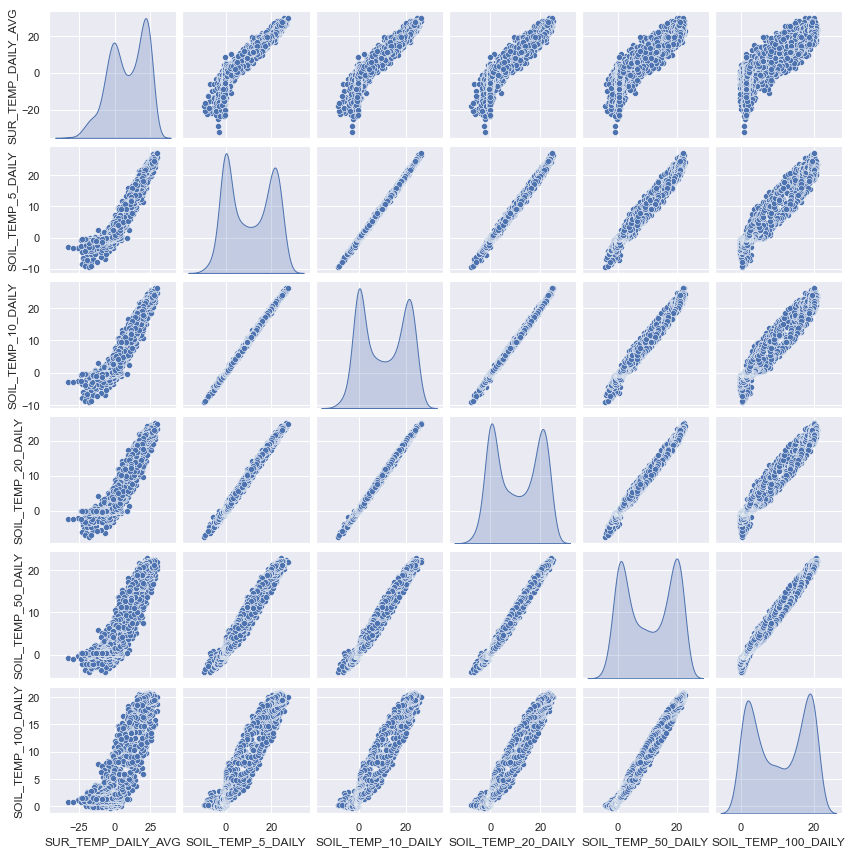

In [149]:
sns.pairplot(filtered_df, height=2, diag_kind="kde")

In [138]:
#p-value
def pearsonr_pval(x,y):
    return stats.pearsonr(x,y)[1]
corr = filtered_df.corr(method=pearsonr_pval)
corr

,SUR_TEMP_DAILY_AVG,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
SUR_TEMP_DAILY_AVG,1.0,0.0,0.0,0.0,0.0,0.0
SOIL_TEMP_5_DAILY,0.0,1.0,0.0,0.0,0.0,0.0
SOIL_TEMP_10_DAILY,0.0,0.0,1.0,0.0,0.0,0.0
SOIL_TEMP_20_DAILY,0.0,0.0,0.0,1.0,0.0,0.0
SOIL_TEMP_50_DAILY,0.0,0.0,0.0,0.0,1.0,0.0
SOIL_TEMP_100_DAILY,0.0,0.0,0.0,0.0,0.0,1.0


## Filling gaps in filtered datasets

### Window linear-regression function for small gaps and ARIMA (with exog parameter) for large ones

In [336]:
from sklearn import linear_model

def fill_gaps_linear(input_array, nodata, window_size=100, dead_recursion=False, max_gap_size=5):    
    reverse_mode=False
    output_array = np.copy(input_array)
    gaps_indeces=(np.array(np.where(output_array==nodata))[0]).tolist()
    gap_size=0
    gaps_list=[]
    for index in gaps_indeces:
        gaps_list.append(index)
        gap_size+=1
        if index+1 not in gaps_indeces:
            if gap_size>max_gap_size:               
                for gap in gaps_list:
                    gaps_indeces.remove(gap)     
            
            gaps_list=[]
            gap_size=0     
    for index in gaps_indeces:
        if index<window_size*2:
            reverse_mode=True
        if index>window_size*2 and len(np.argwhere(output_array[index-window_size*2:index]==nodata))>0:
            reverse_mode=True
        if index>window_size*2 and len(np.argwhere(output_array[index-window_size*2:index]==nodata))==0:
            x_train=[]
            y_train=[]
            pre_set=output_array[index-window_size*2:index]
            for i in range(window_size):
                y=pre_set[window_size*2-i-1]
                y_train.append(y)
                x=pre_set[window_size*2-i-3:window_size*2-i-1]
                x_train.append(x.tolist())
            sample_predictors=output_array[index-2:index]
            regr = linear_model.LinearRegression()
            regr.fit(x_train, y_train)
            y_pred = regr.predict([sample_predictors])            
            output_array[index]=y_pred[0]
    if reverse_mode==True and dead_recursion==False:
        reversed_input=np.fliplr([np.array(output_array)])[0]
        output_array=fill_gaps_linear(reversed_input,  nodata, window_size=window_size*1, dead_recursion=True)
        output_array=np.fliplr([np.array(output_array)])[0]
    return output_array

def fill_gaps_arima(input_array, exog_variables_list, nodata):
    output_array = np.copy(input_array)
    gaps_indeces=(np.array(np.where(output_array==nodata))[0]).tolist()
    gaps_list=[]
    for index in gaps_indeces:
        gaps_list.append(index)
        if index+1 not in gaps_indeces:
            fc_size=len(gaps_list)
            train=output_array[:gaps_list[0]]
            for variable in exog_variables_list:
                exog_train=variable[:gaps_list[0]]
                exog_test=variable[gaps_list[0]:gaps_list[-1]+1]
                if (np.array(np.where(exog_train==nodata))).shape[1]==0 and (np.array(np.where(exog_test==nodata))).shape[1]==0:
                    break
                else:
                    exog_train=[]
                    exog_test=[]
            
            if len(exog_train)!=0:
                print('Exog mode')
                fitted_model_exog = ARIMA(train, order=(3,0,1), exog=exog_train).fit(disp=0)
                fc_exog, se, conf = fitted_model_exog.forecast(fc_size, alpha=0.05, exog=exog_test)                
                output_array[gaps_list[0]:gaps_list[-1]+1]=fc_exog
            if len(exog_train)==0:
                print('Not Exog mode')
                fitted_model_exog = ARIMA(train, order=(3,0,1)).fit(disp=0)
                fc_exog, se, conf = fitted_model_exog.forecast(fc_size, alpha=0.05)                
                output_array[gaps_list[0]:gaps_list[-1]+1]=fc_exog
            break
    return output_array

### Window linear-regression function application

In [350]:
plt.rcParams['figure.figsize'] = [17, 3]
no_gaps_folder='C:/Users/Julia/Documents/ITMO/Statistical_data_analysis/Full_project/no_gaps_data'
list_with_large_gaps=[]
for file in os.listdir(parsed_data_folder):
    df=pd.read_csv(os.path.join(parsed_data_folder, file), sep=' ', header=None)
    df[1] = pd.to_datetime(df[1], format='%Y%m%d')

    l_SURF=fill_gaps_linear(df[14], -9999)
    l_5=fill_gaps_linear(df[23], -9999)
    l_10=fill_gaps_linear(df[24], -9999)
    l_20=fill_gaps_linear(df[25], -9999)
    l_50=fill_gaps_linear(df[26], -9999)
    l_100=fill_gaps_linear(df[27], -9999)
       
    if (np.array(np.where(np.array(l_SURF)==-9999))).shape[1]==0 and (np.array(np.where(np.array(l_5)==-9999))).shape[1]==0 and (np.array(np.where(np.array(l_10)==-9999))).shape[1]==0 and (np.array(np.where(np.array(l_20)==-9999))).shape[1]==0 and (np.array(np.where(np.array(l_50)==-9999))).shape[1]==0 and (np.array(np.where(np.array(l_100)==-9999))).shape[1]==0:   
        data={'LST_DATE':df[1],
                'SUR_TEMP_DAILY_AVG':l_SURF,
                'SOIL_TEMP_5_DAILY':l_5,
                'SOIL_TEMP_10_DAILY':l_10,
                'SOIL_TEMP_20_DAILY':l_20,
                'SOIL_TEMP_50_DAILY':l_50,
                'SOIL_TEMP_100_DAILY':l_100}
        no_gaps_df = pd.DataFrame(data, columns = ['LST_DATE', 'SUR_TEMP_DAILY_AVG', 'SOIL_TEMP_5_DAILY', 'SOIL_TEMP_10_DAILY',
                                                   'SOIL_TEMP_20_DAILY', 'SOIL_TEMP_50_DAILY', 'SOIL_TEMP_100_DAILY'])
        #no_gaps_df.to_csv(os.path.join(no_gaps_folder, file), index=False)
    else:
        list_with_large_gaps.append(file) 
print('Stations with gaps size more than 5 days:\n')
print(list_with_large_gaps)

Stations with gaps size more than 5 days:

['AL_Selma_13_WNW.txt', 'AR_Batesville_8_WNW.txt', 'CA_Bodega_6_WSW.txt', 'CA_Yosemite_Village_12_W.txt', 'IL_Champaign_9_SW.txt', 'KS_Oakley_19_SSW.txt', 'LA_Lafayette_13_SE.txt', 'LA_Monroe_26_N.txt', 'MN_Goodridge_12_NNW.txt', 'MO_Joplin_24_N.txt', 'MS_Holly_Springs_4_N.txt', 'NE_Lincoln_8_ENE.txt', 'NY_Ithaca_13_E.txt', 'NY_Millbrook_3_W.txt', 'OR_John_Day_35_WNW.txt', 'PA_Avondale_2_N.txt', 'TX_Bronte_11_NNE.txt', 'WV_Elkins_21_ENE.txt']


#### *Large-size gaps was filled with individual parameters, detailed processind is in file ./gap_filling_individual_tests.ipynb*